In [6]:
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# Step 1: Toy power spectra
k = np.logspace(-3, 1, 1000)  # h/Mpc
P_nobao = k**-2 * np.exp(-k / 0.2)
P_bao = P_nobao * (1 + 0.05 * np.sin(2 * np.pi * k * 105))  # BAO bump at ~105 Mpc/h

# Step 2: Interpolate to regular grid
k_linear = np.linspace(k.min(), k.max(), 2048)
P_nobao_interp = np.exp(np.interp(np.log(k_linear), np.log(k), np.log(P_nobao)))
P_bao_interp = np.exp(np.interp(np.log(k_linear), np.log(k), np.log(P_bao)))

# Step 3: Compute xi(r) via Hankel-like transform
r = np.linspace(1, 200, 500)  # Mpc/h
kr = np.outer(k_linear, r)
sinc_matrix = np.sinc(kr / np.pi)

k_sq_P_nobao = k_linear**2 * P_nobao_interp
k_sq_P_bao = k_linear**2 * P_bao_interp

xi_nobao = np.trapz(k_sq_P_nobao[:, None] * sinc_matrix, x=k_linear, axis=0) / (2 * np.pi**2)
xi_bao = np.trapz(k_sq_P_bao[:, None] * sinc_matrix, x=k_linear, axis=0) / (2 * np.pi**2)


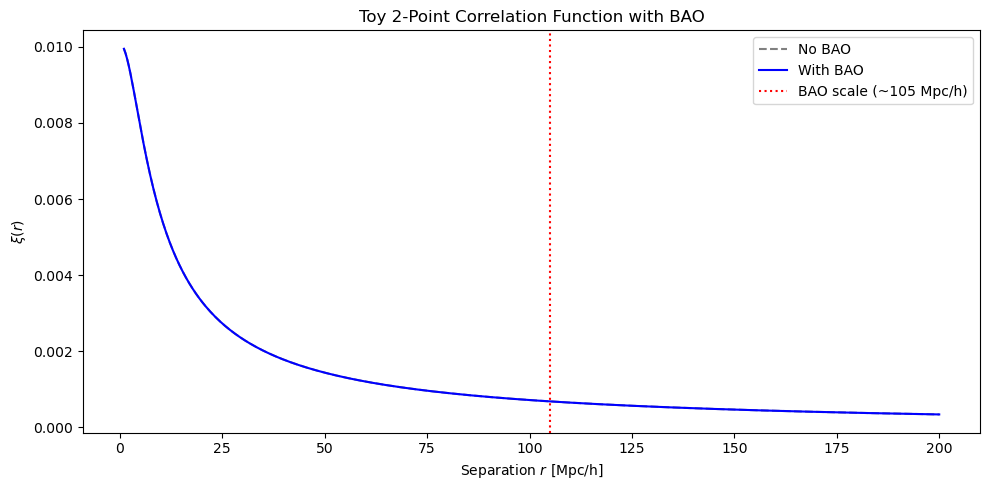

In [8]:
# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(r, xi_nobao, label="No BAO", color='gray', linestyle='--')
plt.plot(r, xi_bao, label="With BAO", color='blue')
#plt.ylim(bottom=-0.1)
plt.axvline(105, color='red', linestyle=':', label="BAO scale (~105 Mpc/h)")
plt.xlabel("Separation $r$ [Mpc/h]")
plt.ylabel(r"$\xi(r)$")
plt.title("Toy 2-Point Correlation Function with BAO")
plt.legend()
plt.tight_layout()
plt.show()

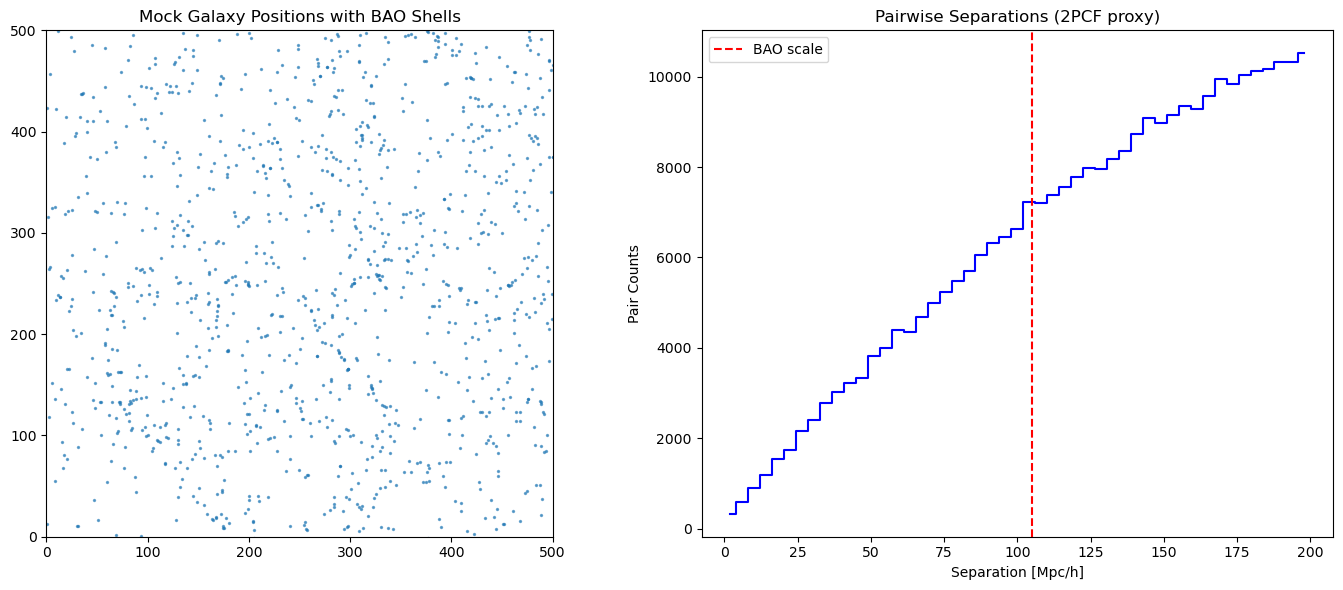

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# --- Parameters ---
n_shells = 30
n_points_per_shell = 30
bao_radius = 105  # Mpc/h
box_size = 500  # Mpc/h
rng = np.random.default_rng(42)

# --- Generate BAO shells ---
centers = rng.uniform(0, box_size, size=(n_shells, 2))
points = []

for cx, cy in centers:
    angles = rng.uniform(0, 2 * np.pi, n_points_per_shell)
    xs = cx + bao_radius * np.cos(angles)
    ys = cy + bao_radius * np.sin(angles)
    points.append(np.column_stack([xs, ys]))

points = np.vstack(points)

# --- Optional: add uniform background
n_random = 500
rand_x = rng.uniform(0, box_size, n_random)
rand_y = rng.uniform(0, box_size, n_random)
points = np.vstack([points, np.column_stack([rand_x, rand_y])])

# --- Compute 2PCF ---
coords = points
dists = distance.pdist(coords)
bins = np.linspace(0, 200, 50)
dd_counts, edges = np.histogram(dists, bins=bins)
r_centers = 0.5 * (edges[1:] + edges[:-1])

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: Galaxy positions
axs[0].scatter(points[:, 0], points[:, 1], s=2, alpha=0.6)
axs[0].set_aspect('equal')
axs[0].set_title("Mock Galaxy Positions with BAO Shells")
axs[0].set_xlim(0, box_size)
axs[0].set_ylim(0, box_size)

# Right: 2PCF histogram
axs[1].plot(r_centers, dd_counts, drawstyle='steps-mid', color='blue')
axs[1].axvline(bao_radius, color='red', linestyle='--', label='BAO scale')
axs[1].set_xlabel("Separation [Mpc/h]")
axs[1].set_ylabel("Pair Counts")
axs[1].set_title("Pairwise Separations (2PCF proxy)")
axs[1].legend()

plt.tight_layout()
plt.show()
